In [21]:
from math import sqrt
from numpy import concatenate
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    data：作为列表或二维 NumPy 数组的观察序列。
    n_in：作为输入 ( X )的滞后观察数。值可能介于 [1..len(data)] 之间 可选。默认为 1。
    n_out：作为输出的观察数（y）。值可能介于 [0..len(data)-1] 之间。可选的。默认为 1。
    dropnan：布尔值是否删除具有 NaN 值的行。可选的。默认为真。
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]  # 特征数
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
# load dataset

def load_data(file_name):
    df = np.load(file_name, allow_pickle=True)
    df_ = df[:, 1:] # 去除时间列,每一行表示一个小时

    data_all = df_

    encoder = LabelEncoder()
    data_all[:,0] = encoder.fit_transform(data_all[:, 0])
    data_all = data_all
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(data_all)

    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
    
    return reframed, scaler


In [24]:
## R2
import keras.backend as K
def r2(y_true, y_pred):
    y_true = K.constant(y_true)
    y_pred = K.constant(y_pred)
    a = K.square(y_pred - y_true)
    b = K.sum(a)
    c = K.mean(y_true)
    d = K.square(y_true - c)
    e = K.sum(d)
    f = 1 - b/e
    return f


def RE(y_true, y_pred):
    E = K.abs(K.constant(y_true) - K.constant(y_pred))/K.constant(y_true)
    return E

def delt_t(y_true, y_pred):
#     y_true = K.constant(y_true)
#     y_pred = K.constant(y_pred)
# #     test_y = K.constant(test_y)
# #     pred = K.constant(pred)
    
#     t_true = K.equal(y_true, y_true)
#     t_true_ = K.tf.where(t_true)[-1]
    
#     t_pred = K.equal(y_true, y_pred)
#     t_pred_ = K.tf.where(t_pred)[-1]
    y_true = y_true
    y_pred = y_pred
#     test_y = K.constant(test_y)
#     pred = K.constant(pred)
    
    t_true = np.equal(y_true, y_true)
    print(t_true.shape)
    t_true_ = np.where(t_true)[-1]
    print(t_true_.shape)
    t_pred = np.equal(y_true, y_pred)
    print(t_pred.shape)
    t_pred_ = np.where(t_pred)[-1]
    print(t_pred_.shape)
    delta_time = t_true_ - t_pred_
    
    return delta_time

# 加载实验数据集

In [25]:
train_data_1, scaler = load_data('./data/data_2003.npy')
train_data_2, scaler = load_data('./data/data_2004.npy')
train_data_3, scaler = load_data('./data/data_2005.npy')
train_data_4, scaler = load_data('./data/data_2006.npy')
train_data_5, scaler = load_data('./data/data_2007.npy')
train_data_6, scaler = load_data('./data/data_2008.npy')

test_data_1, scaler = load_data('./data/data_2009.npy')
test_data_2, scaler = load_data('./data/data_2010.npy')


In [26]:
train_data = pd.concat([train_data_1, train_data_2, train_data_3, train_data_4, train_data_5, train_data_6])
test_data = pd.concat([test_data_1, test_data_2])

print(train_data.shape, test_data.shape)

(13454, 8) (5034, 8)


In [27]:
train_data = np.array(train_data)
test_data = np.array(test_data)

In [28]:
train_data

array([[0.00896861, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00822123],
       [0.00822123, 0.        , 0.        , ..., 0.        , 0.05376344,
        0.00747384],
       [0.00747384, 0.        , 0.        , ..., 0.        , 0.05376344,
        0.00597907],
       ...,
       [0.06675749, 0.        , 0.        , ..., 0.        , 0.        ,
        0.0653951 ],
       [0.0653951 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0626703 ],
       [0.0626703 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0599455 ]])

In [29]:
## Split into train and test sets
train_x, train_y = train_data[:, :-1], train_data[:, -1]
test_x, test_y = test_data[:, :-1], test_data[:, -1]

## Reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(13454, 1, 7)
(5034, 1, 7)
(13454,)
(5034,)


# 搭建模型并训练

In [30]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint


filepath = "./results/lstm_1.h5"
# 中途训练效果提升, 则将文件保存, 每提升一次, 保存一次
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

In [31]:
## Build model
model = Sequential()

model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

## fit mdoel
history = model.fit(train_x, train_y, batch_size=64, epochs=50, validation_split=0.2, verbose=2, shuffle=False)


Train on 10763 samples, validate on 2691 samples
Epoch 1/50
 - 1s - loss: 0.0908 - mae: 0.2357 - val_loss: 0.0374 - val_mae: 0.1709
Epoch 2/50
 - 1s - loss: 0.0205 - mae: 0.1208 - val_loss: 0.0114 - val_mae: 0.0944
Epoch 3/50
 - 1s - loss: 0.0037 - mae: 0.0441 - val_loss: 7.2672e-04 - val_mae: 0.0184
Epoch 4/50
 - 1s - loss: 4.7809e-04 - mae: 0.0111 - val_loss: 5.6277e-04 - val_mae: 0.0122
Epoch 5/50
 - 1s - loss: 4.3174e-04 - mae: 0.0099 - val_loss: 5.4900e-04 - val_mae: 0.0118
Epoch 6/50
 - 1s - loss: 4.1166e-04 - mae: 0.0095 - val_loss: 5.3657e-04 - val_mae: 0.0115
Epoch 7/50
 - 1s - loss: 3.9547e-04 - mae: 0.0090 - val_loss: 5.2950e-04 - val_mae: 0.0112
Epoch 8/50
 - 1s - loss: 3.8447e-04 - mae: 0.0087 - val_loss: 5.2661e-04 - val_mae: 0.0111
Epoch 9/50
 - 1s - loss: 3.7674e-04 - mae: 0.0086 - val_loss: 5.3037e-04 - val_mae: 0.0112
Epoch 10/50
 - 1s - loss: 3.6930e-04 - mae: 0.0083 - val_loss: 5.3705e-04 - val_mae: 0.0113
Epoch 11/50
 - 1s - loss: 3.6275e-04 - mae: 0.0081 - val_los

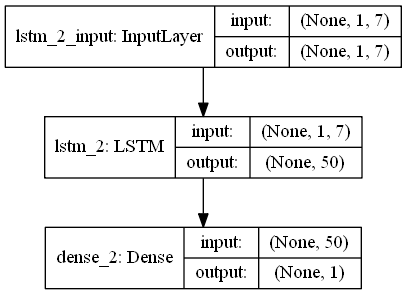

In [34]:
from keras.utils import plot_model

plot_model(model, './results/model.png', show_shapes=True)

In [35]:
hist = history.history
hist.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

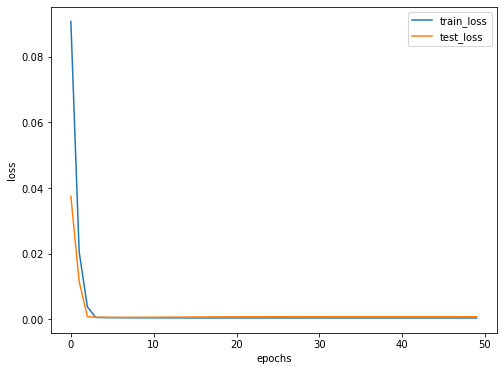

In [36]:
## 绘图
fig = plt.figure(figsize=(8,6))

plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

fig.savefig('./results/lstm_1'+'loss.png')

# 实验结果

In [16]:
# np.save('./results/pred', y_hat)
# np.save('./data/train_x', train_x)
# np.save('./data/train_y', train_y)
# np.save('./data/test_x', test_x)
# np.save('./data/test_y', test_y)


# y_hat = np.load('./results/pred.npy','r')
# test_x = np.save('./data/test_x', 'r')
# test_y = np.save('./data/test_y', 'r')

In [37]:
y_hat = model.predict(test_x)
y_hat.shape, y_hat

((5034, 1),
 array([[-0.00257183],
        [-0.00252807],
        [-0.00252807],
        ...,
        [ 0.09357359],
        [ 0.09357359],
        [ 0.09357359]], dtype=float32))

In [38]:
## 计算真实数据

true_data = np.load('./data/data_2009.npy','r')
true_data_chenhe = true_data[:, 1]
true_data_chenhe_max = np.max(true_data_chenhe)
print(true_data_chenhe.shape, true_data_chenhe)
print("真实数据最大值：",true_data_chenhe_max)


pred_max = np.max(y_hat)
print("预测数据均值：", pred_max)

Q_scale = true_data_chenhe_max/pred_max
print("放大倍数：",Q_scale)

pred_data = y_hat * Q_scale

print("预测真实数据：", pred_data)

(3415,) [0.7  0.7  0.7  ... 7.6  8.34 9.07]
真实数据最大值： 364.0
预测数据均值： 0.9873667
放大倍数： 368.6573678511855
预测真实数据： [[-0.94812316]
 [-0.93199193]
 [-0.93199193]
 ...
 [34.496593  ]
 [34.496593  ]
 [34.496593  ]]


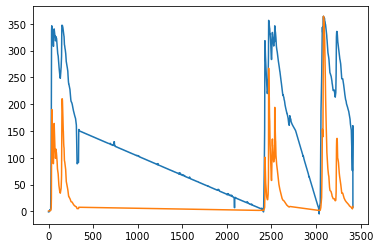

In [39]:
plt.plot(pred_data[:3415])
plt.plot(true_data_chenhe)

In [40]:
# Make a prediction
y_hat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))

# invert scaling for forecast
# scaler = MinMaxScaler(feature_range=(0,1))
inv_yhat = concatenate((y_hat, test_x[:, 1:]), axis=1)
# print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

## Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print("Test RMSE: %.4f" %rmse)

Test RMSE: 27.3825


In [41]:
# 决定系数
R2 = r2(test_y, y_hat)
R2

<tf.Tensor: shape=(), dtype=float32, numpy=0.99341863>

In [42]:
# 洪峰相对误差
RE = RE(test_y, y_hat)
RE

<tf.Tensor: shape=(5034, 1), dtype=float32, numpy=
array([[       inf],
       [       inf],
       [       inf],
       ...,
       [0.06662317],
       [0.06662317],
       [0.06662317]], dtype=float32)>

In [43]:
# # 峰现误差

# delta_y = test_y - y_hat
# print(delta_y.shape, delta_y)

# t_true = np.equal(test_y, test_y)
# print(t_true.shape)
# t_true_ = np.where(t_true)[0]
# print( 't_true_:', t_true_)

# t_pred = np.equal(y_hat, y_hat)
# print(t_pred.shape)
# t_pred_ = np.where(t_pred)[0]
# print('t_pred_:',t_pred_)

# delta_time = t_true_ - t_pred_

# delta_time

# delta_t = delt_t(test_y, y_hat)
# delt_t


t1 = np.argmax(test_y)
t2 = np.argmax(y_hat)

delt_t = t2-t1
print('真实洪峰出现时间：', t1)
print('预测洪峰出现时间：', t2)
print("峰现误差：", delt_t)

真实洪峰出现时间： 3083
预测洪峰出现时间： 3084
峰现误差： 1
